# Settings

In [ ]:
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/data_loading.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/scoring.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_methods.R")
source("https://raw.githubusercontent.com/dwolffram/covid19-ensembles/master/ensemble_functions.R")

In [ ]:
library(tidytext)

In [8]:
options(repr.plot.width=15, repr.plot.height=8, repr.plot.res = 300)

In [10]:
theme_set(theme_gray(base_size = 18))

In [4]:
scores <- load_scores("scores/scores_cases_2021-06-12.csv", long_format=TRUE) %>%
  filter(!model %in% c("CU-scenario_high", "CU-scenario_mid", "CU-scenario_low", "CU-nochange")) %>%
  filter(location != "US")

# Mean WIS

In [13]:
scale_x_reordered <- function(..., sep = "___") {
  reg <- paste0(sep, ".+$")
  ggplot2::scale_x_discrete(labels = function(x) parse(text=gsub(reg, "", x)), ...)
}

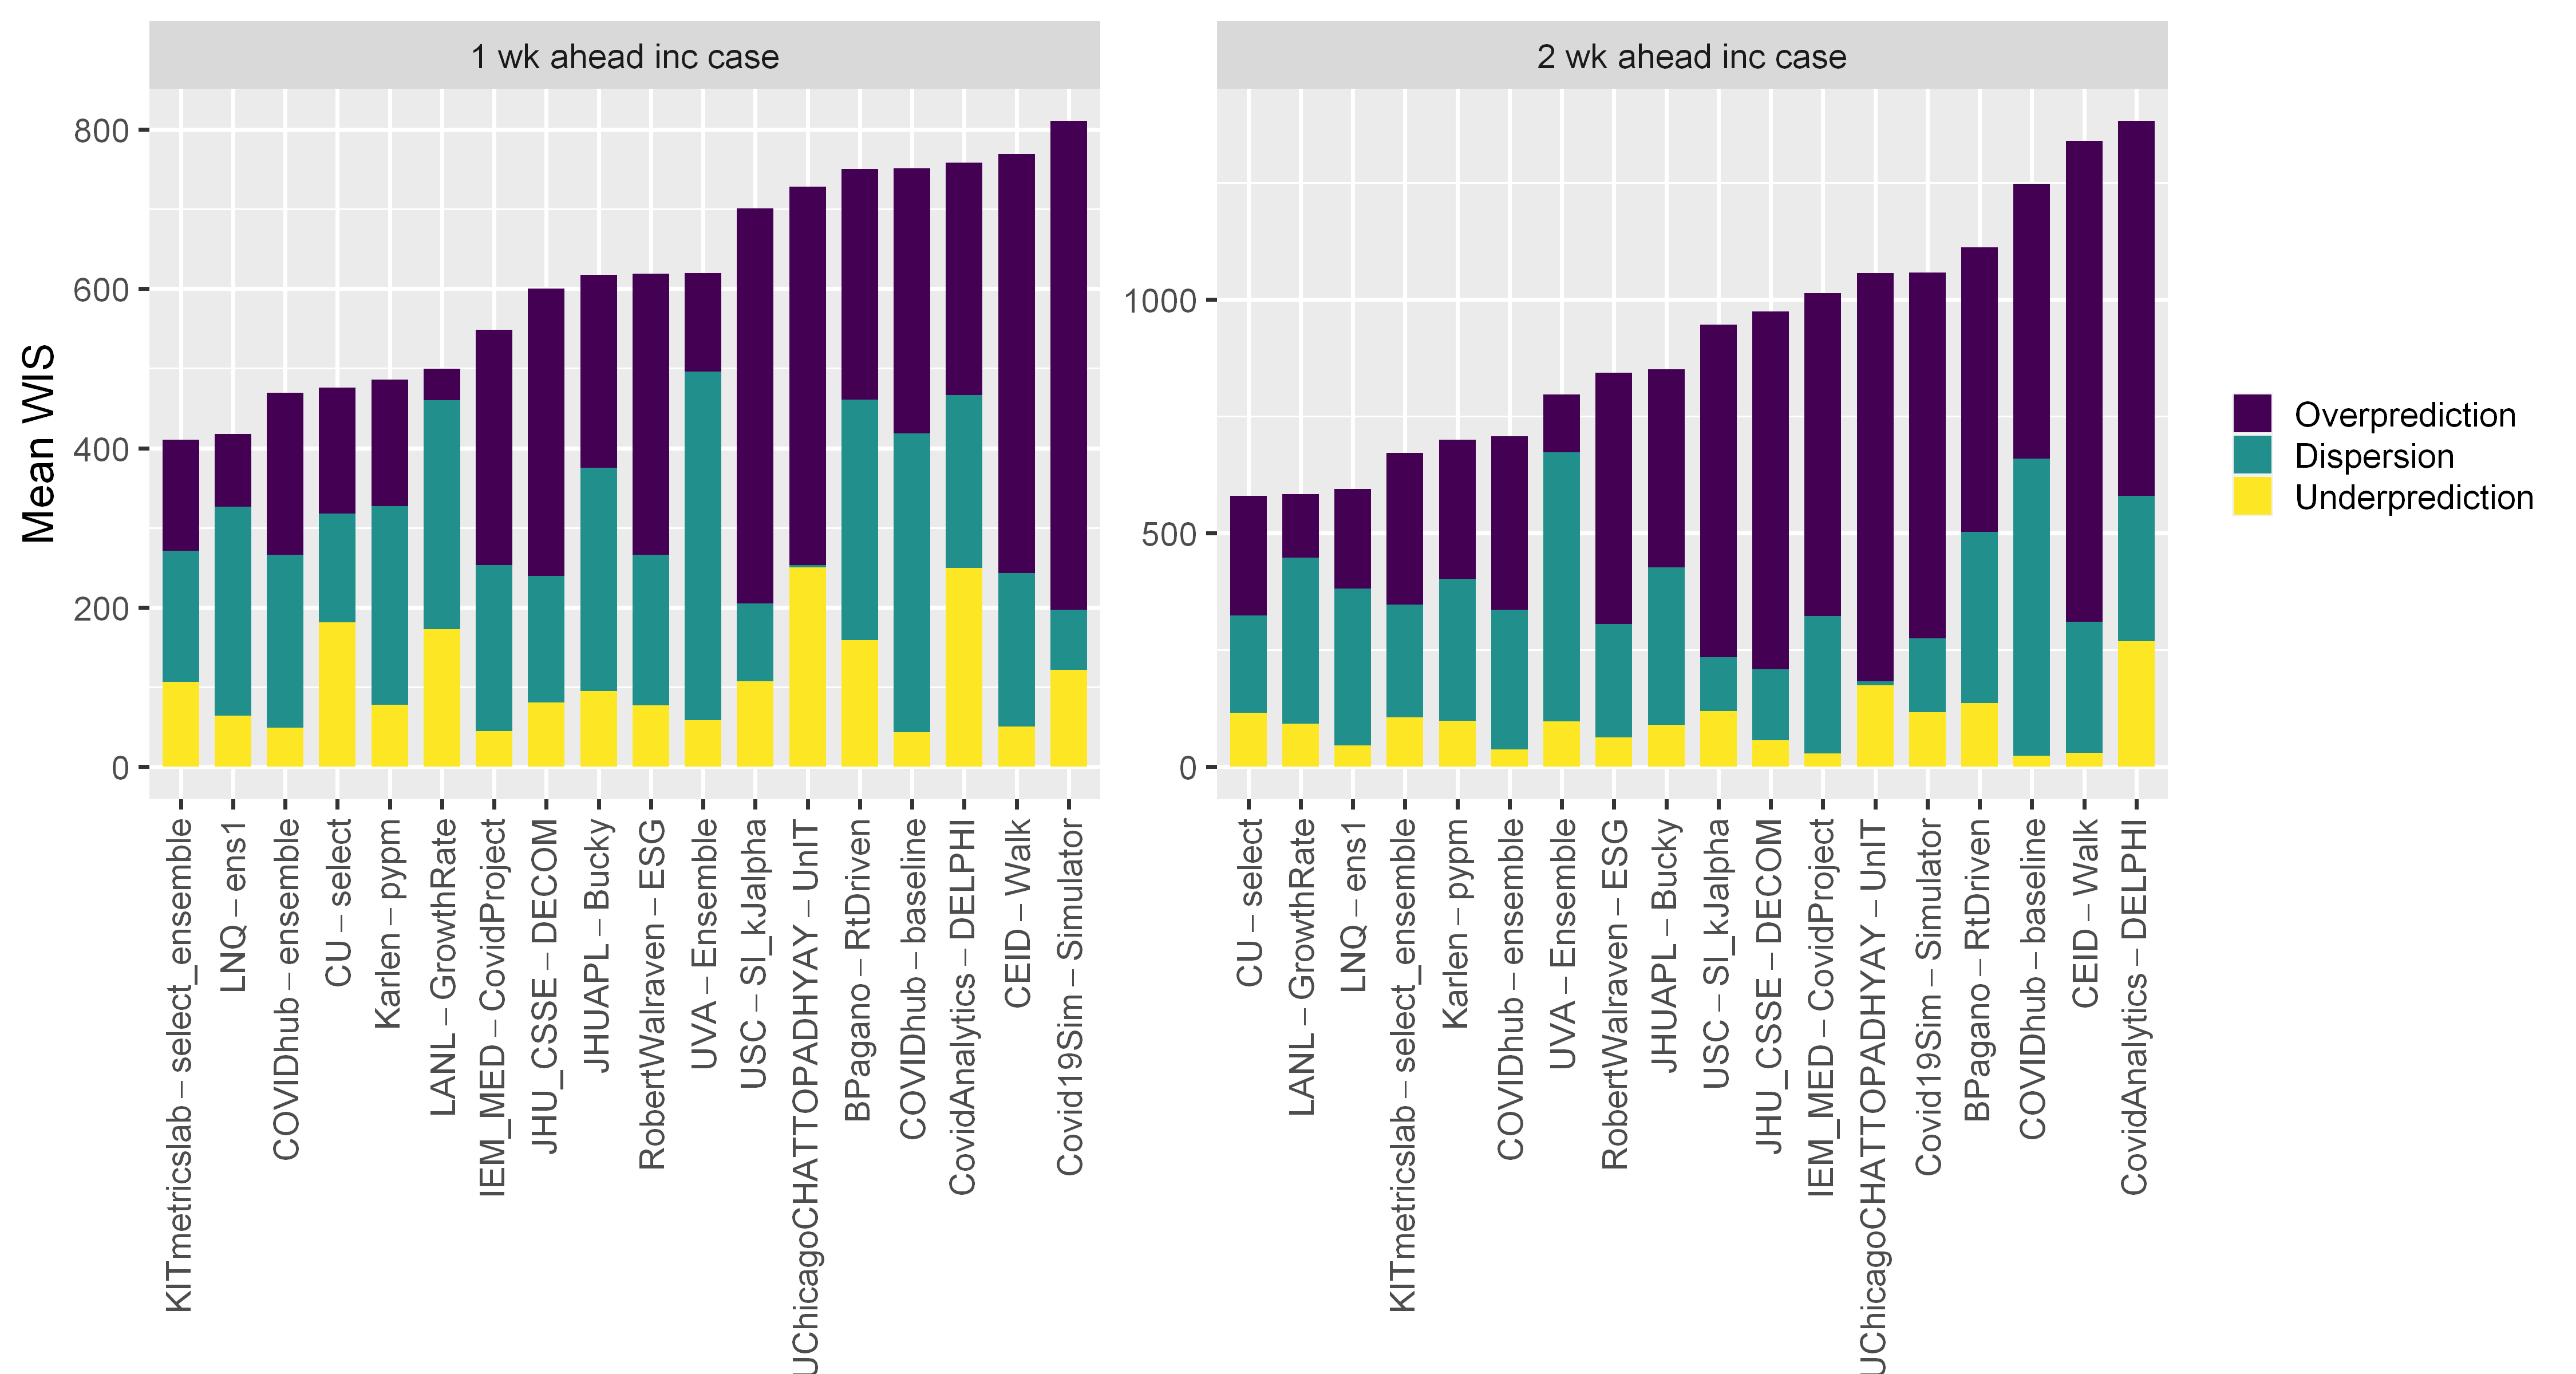

In [15]:
ggplot(subset(scores, score %in% c("wgt_pen_l", "wgt_iw", "wgt_pen_u")), 
       aes(x=reorder_within(model, value, target), y=value,
           fill=factor(score, levels=c("wgt_pen_l", "wgt_iw", "wgt_pen_u")))) +
  scale_x_reordered() +
  geom_bar(position="stack", stat="summary", fun=mean, width=0.7) +
  facet_wrap("target", scales="free", drop=TRUE) +
  theme(axis.text.x=element_text(vjust=0.5, angle=90, hjust=1), 
        legend.position = "right") +
  scale_fill_viridis(discrete=TRUE, name = NULL,
                     labels = c("Overprediction", "Dispersion", "Underprediction"))+
  labs(x = NULL,
       y = "Mean WIS")

# Forecasts

In [25]:
add_truth <- function(df){
  target_dict = list("inc case" = "Incident Cases",
                     "inc death" = "Incident Deaths",
                     "cum death" = "Cumulative Deaths")
  
  df$merge_target <- str_sub(df$target, start=12)
  targets <- unique(df$merge_target)
  
  truth_df <- data.frame()
  
  for (target in targets){
    truth <- load_truth(target_dict[[target]]) %>%
      rename(truth = value) %>%
      mutate(merge_target = target)
    
    truth_df <- bind_rows(truth_df, truth)
  }

  df <- df %>%
    left_join(truth_df, by=c("merge_target"="merge_target", "target_end_date"="date", "location"="location")) %>% 
    select(- merge_target)
  
  return(df)
}

In [ ]:
df = read_csv("evaluation/2021-06-12_df_processed.csv")

In [26]:
df <- add_truth(df)

In [27]:
df <- pivot_wider(df, names_from=quantile, names_prefix="value.", values_from=value)

In [34]:
df_ens <- df %>%
filter(model == "KITmetricslab-select_ensemble",
      location == "US")

In [35]:
cols <- colorRampPalette(c("deepskyblue4", "lightgrey"))(2 + 1)[-1]

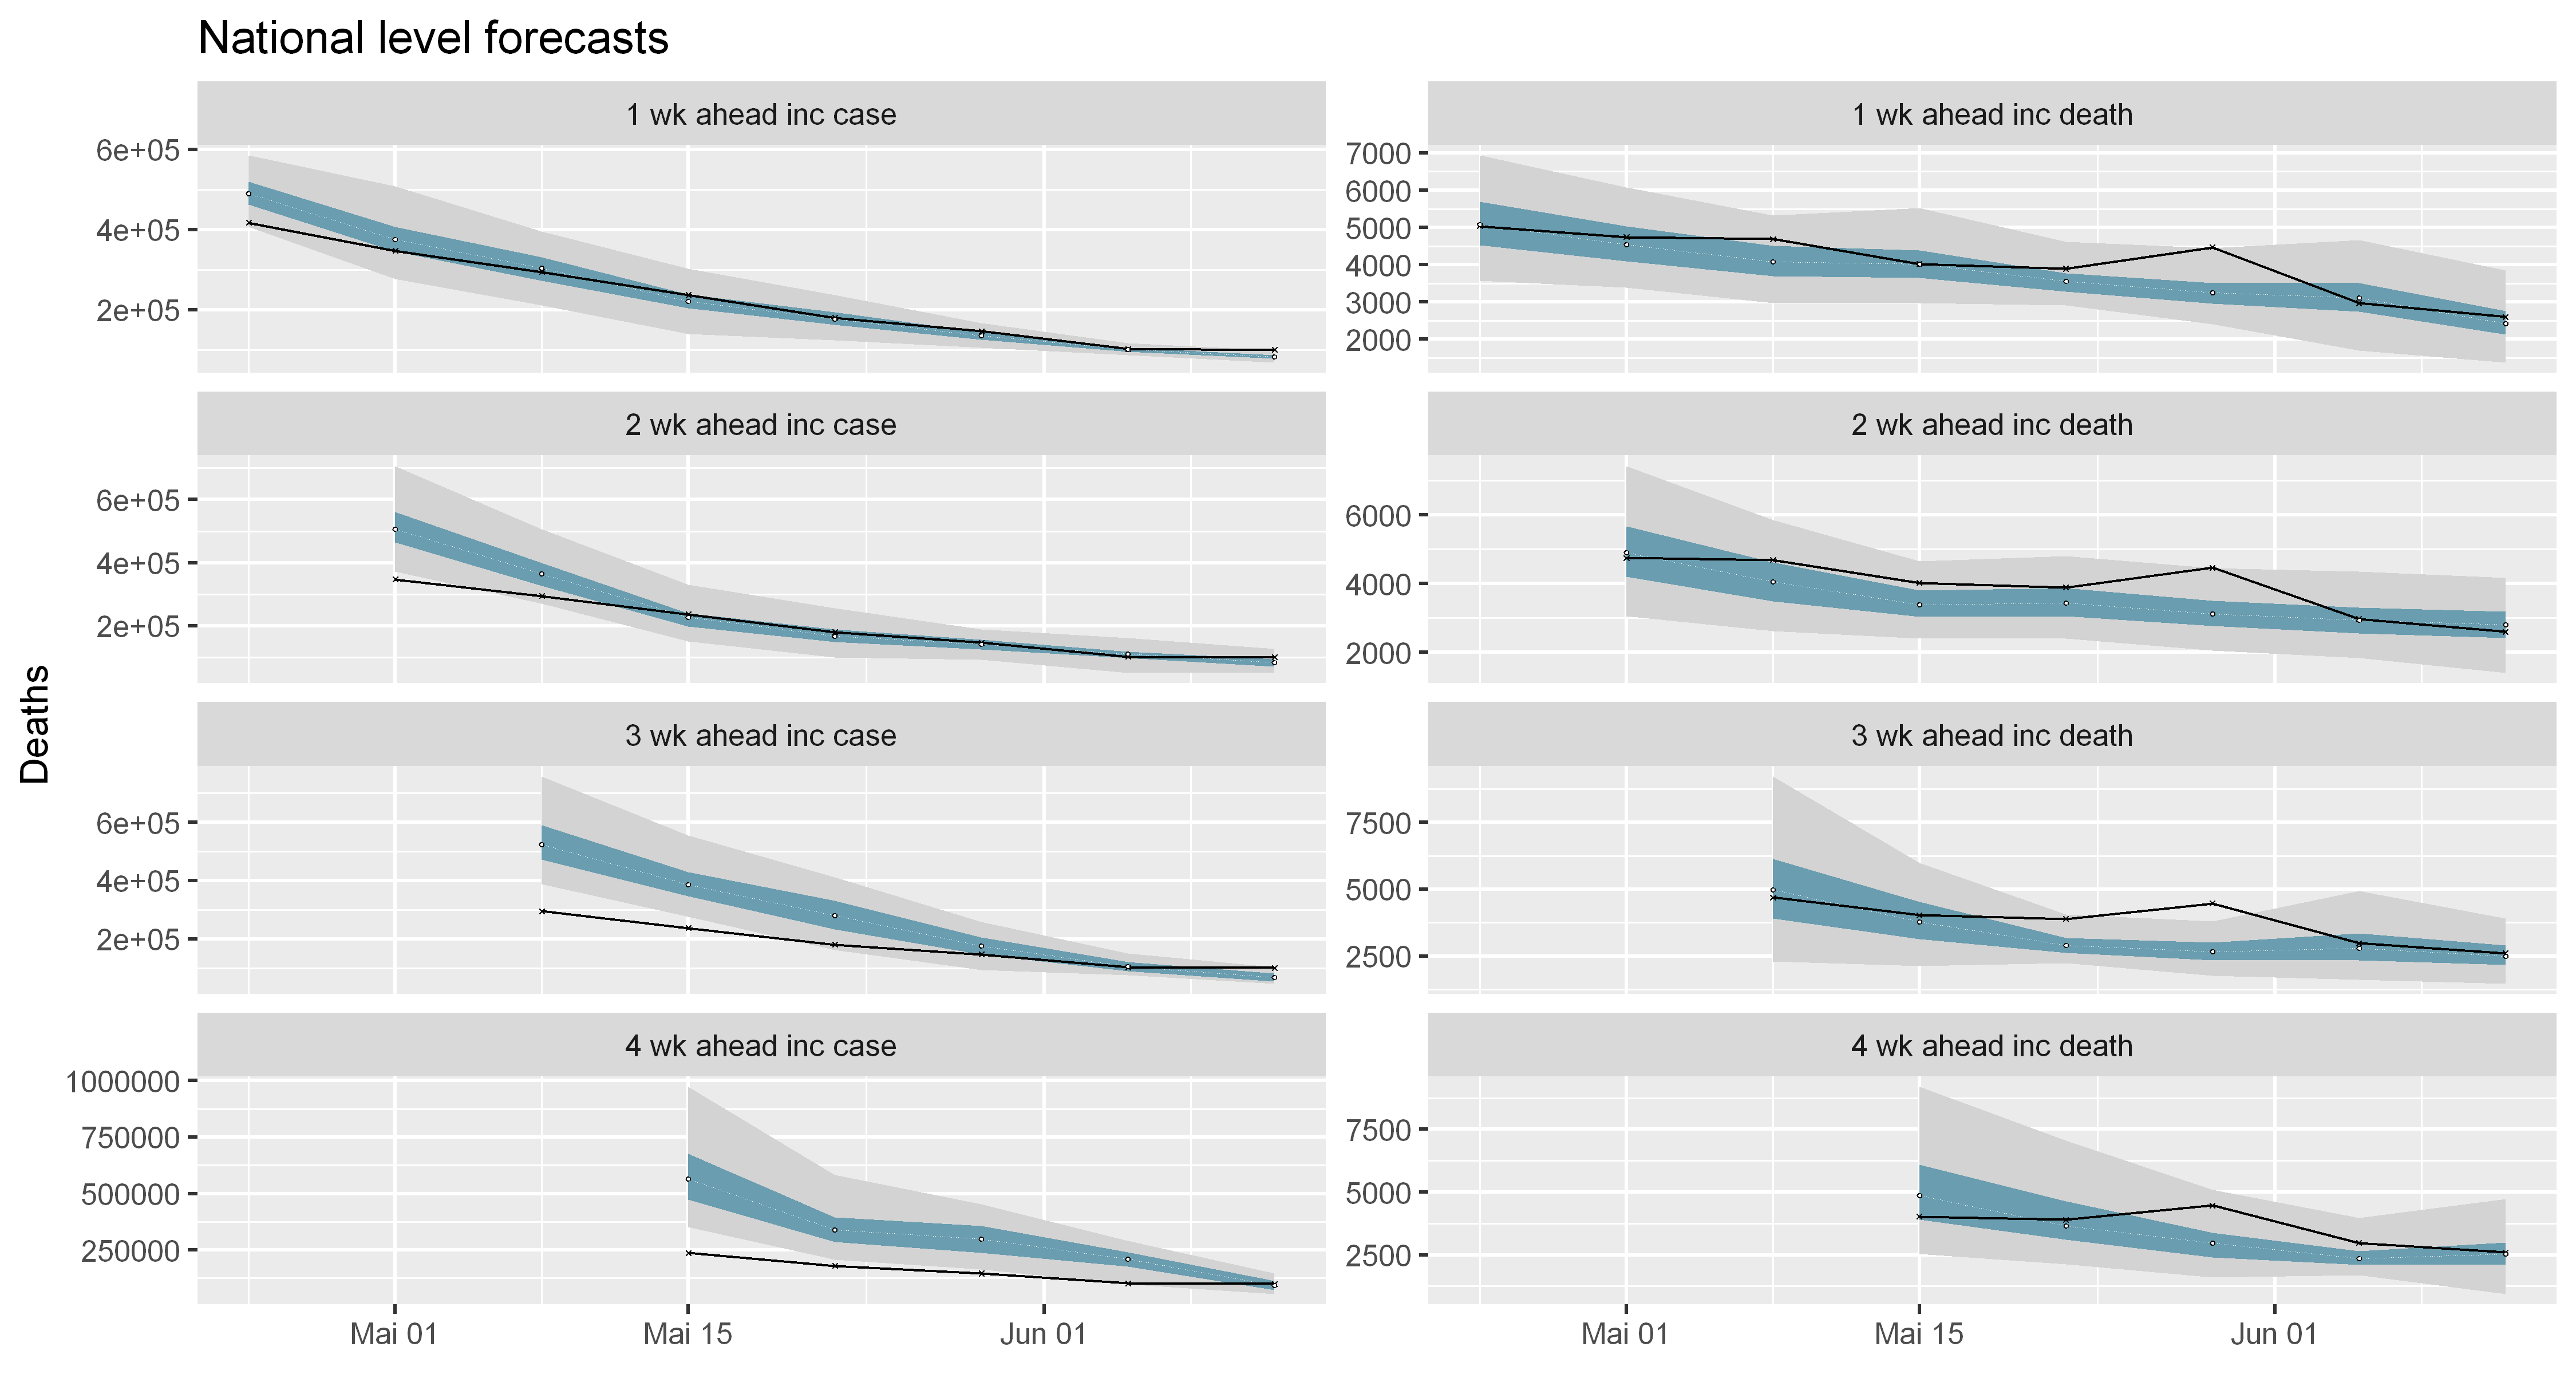

In [45]:
ggplot(df_ens, aes(x=target_end_date, y=truth)) +
  facet_wrap("target", scales="free_y", ncol=2) +
  geom_smooth(aes(y = value.0.5, ymin = value.0.025, ymax = value.0.975), 
              linetype=3, size=0.2, colour="white", fill=cols[2], alpha=1, stat = "identity") +
  geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
              linetype=3, size=0.2, colour="white", fill=cols[1], alpha=1, stat = "identity") +
  geom_line() +
  geom_point(pch = 4, size=0.7) +
  geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=0.7) +
  theme_bw() +
  labs(title="National level forecasts",
       x = NULL,
       y = "Deaths") +
  theme_grey(base_size=16) +
  theme(strip.text.y = element_text(size = 8))

In [46]:
# ggplot(df_ens, aes(x=target_end_date, y=truth)) +
#   facet_grid(rows=vars(location_name), cols=vars(target), scales="free", 
#              labeller = label_wrap_gen(10), # switch="y"
#              ) +
#   geom_smooth(aes(y = value.0.5, ymin = value.0.05, ymax = value.0.95), 
#               linetype=3, size=0.2, colour="white", fill=cols[2], alpha=1, stat = "identity") +
#   geom_smooth(aes(y = value.0.5, ymin = value.0.25, ymax = value.0.75),
#               linetype=3, size=0.2, colour="white", fill=cols[1], alpha=1, stat = "identity") +
#   geom_line() +
#   geom_point(pch = 4, size=0.7) +
#   geom_point(aes(y = value.0.5), pch = 21, col = "black", bg = "white", size=0.7) +
#   theme_bw() +
#   labs(title=NULL,
#        x = NULL,
#        y = "Deaths") +
#   theme_grey(base_size=10) +
#   theme(strip.text.y = element_text(size = 5.5))